In [1]:
from constants import ERA5_BEST_INFERENCE_WANDB_RUN_IDS
from utils import wandb_to_xarray
import xarray as xr
import matplotlib.pyplot as plt
import wandb
xr.set_options(keep_attrs=True)
plt.rcParams['figure.dpi'] = 300

In [2]:
wandb_id = ERA5_BEST_INFERENCE_WANDB_RUN_IDS['15day']
wandb_project = "ace"
variable_names = ["TMP2m", "TMP850", "h500", "VGRD10m", "UGRD10m", "total_water_path"]
units = {"TMP2m": "K", "TMP850": "K", "h500": "m", "VGRD10m": "m/s", "UGRD10m": "m/s", "total_water_path": "kg/m^2"}

In [3]:
rmse_metric_names = [f"inference/mean/weighted_rmse/{name}" for name in variable_names]
metrics = wandb_to_xarray(wandb_project, wandb_id, rmse_metric_names, n_steps=61)

In [4]:
metrics

<xarray.Dataset> Size: 3kB
Dimensions:                                        (time: 61)
Coordinates:
  * time                                           (time) float64 488B 0.0 .....
Data variables:
    inference/mean/weighted_rmse/TMP2m             (time) float64 488B 0.0 .....
    inference/mean/weighted_rmse/TMP850            (time) float64 488B 0.0 .....
    inference/mean/weighted_rmse/h500              (time) float64 488B 0.0 .....
    inference/mean/weighted_rmse/VGRD10m           (time) float64 488B 0.0 .....
    inference/mean/weighted_rmse/UGRD10m           (time) float64 488B 0.0 .....
    inference/mean/weighted_rmse/total_water_path  (time) float64 488B 0.0 .....

In [6]:
for name in metrics:
    shortname = name.split("/")[-1]
    metrics[name].attrs["long_name"] = shortname + " RMSE"

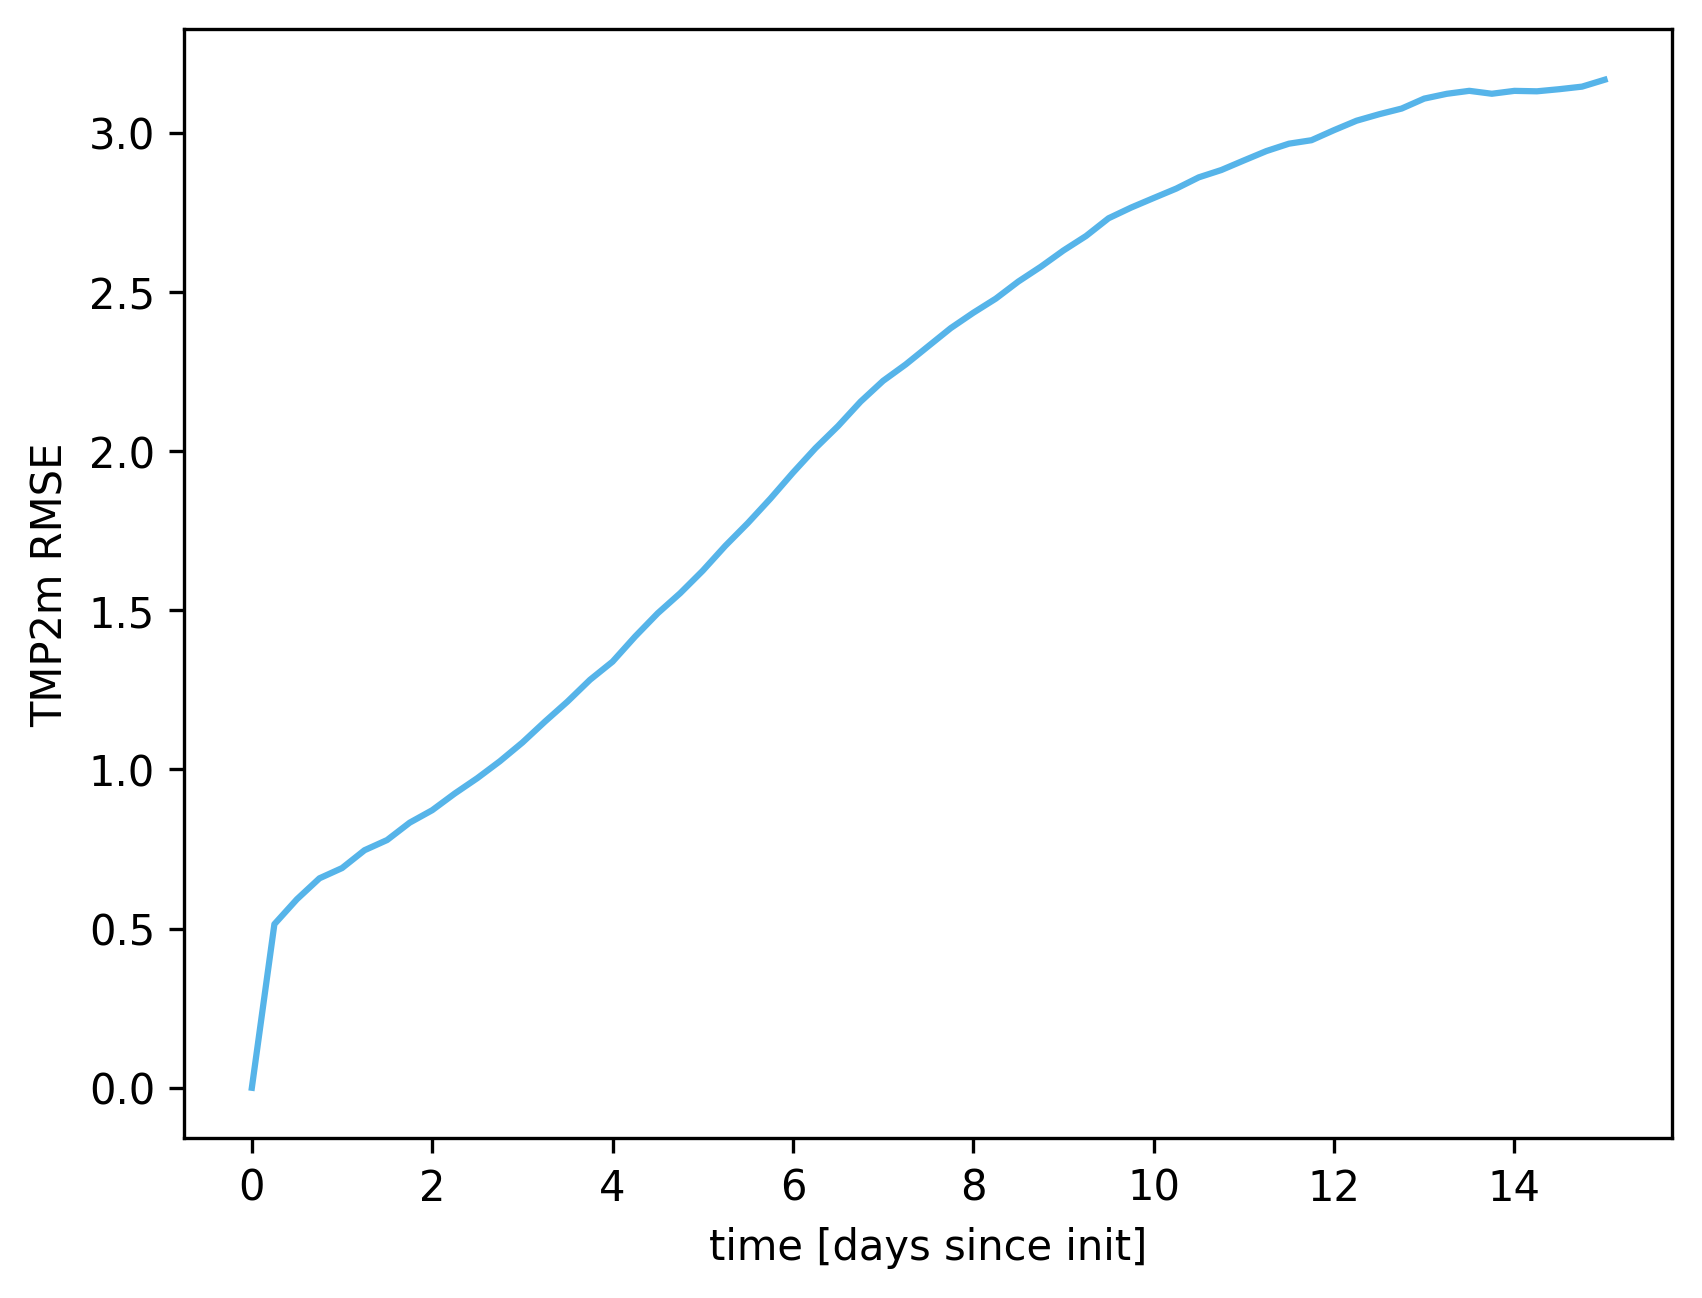

In [7]:
metrics['inference/mean/weighted_rmse/TMP2m'].plot()